# Tensor networks

DisCoPy supports some of the most commonly used libraries for scientific computing: PyTorch, TensorFlow, Jax and NumPy. This allows us to calculate gradients on-the-fly.

## Create a parametrised diagram

Diagram for 'Alice loves Bob':


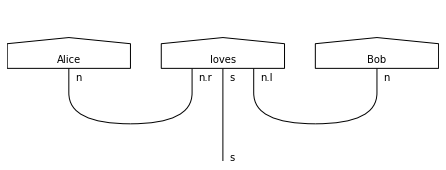

In [1]:
from discopy import Diagram, Id, Cup, Ty, Word
from discopy.grammar import draw

s, n = Ty('s'), Ty('n')
Alice, loves, Bob = Word('Alice', n), Word('loves', n.r @ s @ n.l), Word('Bob', n)

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
diagram = Alice @ loves @ Bob >> grammar

print("Diagram for 'Alice loves Bob':")
draw(diagram, draw_type_labels=True)

In [2]:
from discopy.quantum import Ket, H, Rx, CX, sqrt

def verb_ansatz(phase):
    return Ket(0, 0) >> H @ sqrt(2) @ Rx(phase) >> CX

print(verb_ansatz(0).eval())

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])


Circuit for 'Alice loves Bob':


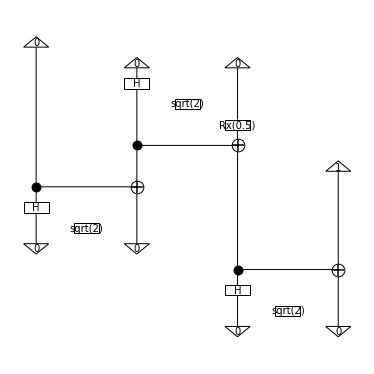

In [3]:
from discopy import CircuitFunctor, qubit

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1),
    loves: verb_ansatz(params['loves'])}

F = lambda params: CircuitFunctor(ob, ar(params))

params0 = {'loves': 0.5}

print("Circuit for 'Alice loves Bob':")
F(params0)(diagram).draw(
    aspect='auto', draw_type_labels=False, figsize=(5, 5))

## Tensorflow

In [4]:
from discopy import Tensor
import tensorflow as tf
import tensornetwork as tn

def mean_squared(y_true, y_pred):
    return tf.abs((y_true - y_pred) ** 2)

loss = []
grads = []
x = tf.convert_to_tensor([0.01])
y_true = tf.convert_to_tensor([1.])
with Tensor.backend('tensorflow'):
    for i in range(50):
        with tf.GradientTape() as g:
            g.watch(x)
            params = {'loves': x}
            y_hat = F({'loves': x})(diagram).measure()
            l = mean_squared(y_true, y_hat)
            loss.append(l)
            dl_dx = g.gradient(l, x)
            grads.append(dl_dx)
            x -= 0.01 * dl_dx
print(f'Final parameter of love: {x}')
params = {'loves': x}

Final parameter of love: [0.44241476]


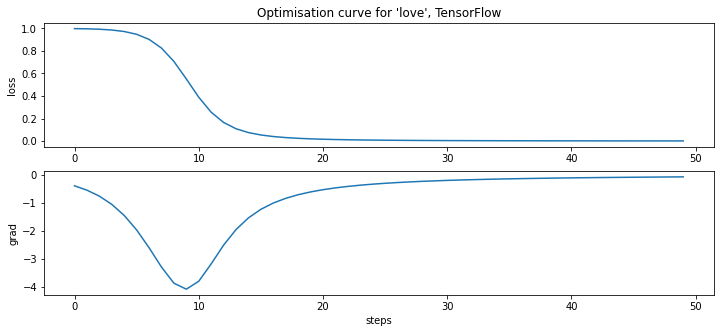

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

plt.subplot(2, 1, 1)
plt.plot(loss)
plt.title("Optimisation curve for 'love', TensorFlow")
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(grads)
plt.xlabel('steps')
plt.ylabel('grad')
plt.show()

## JAX

In [6]:
from discopy import Tensor
import jax.numpy as jnp
from jax import grad

def mean_squared(y_true, y_pred):
    return jnp.abs((y_true - y_pred) ** 2)

loss = []
grads = []
x = jnp.array([0.01])
y_true = jnp.array([1.])
with Tensor.backend('jax') as backend:
    evaluate = lambda x: mean_squared(y_true, F({'loves': x})(diagram).measure())[0]
    d_eval_dx = grad(evaluate)
    for i in range(50):
        l = evaluate(x)
        loss.append(l)
        dl_dx = d_eval_dx(x)
        grads.append(dl_dx)
        x -= 0.01 * dl_dx
print(f'Final parameter of love: {x}')

Final parameter of love: [0.44241485]


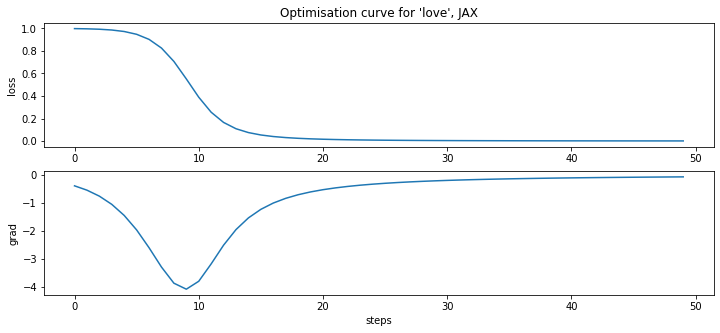

In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

plt.subplot(2, 1, 1)
plt.plot(loss)
plt.title("Optimisation curve for 'love', JAX")
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(grads)
plt.xlabel('steps')
plt.ylabel('grad')
plt.show()

## PyTorch

In [8]:
from discopy import Tensor
import torch
import tensornetwork as tn

def mean_squared(y_true, y_pred):
    return torch.abs((y_true - y_pred) ** 2)

loss = []
grad = []
x = torch.tensor([0.01], dtype=torch.complex128, requires_grad=True)
y_true = torch.as_tensor([1.])
with Tensor.backend('torch'), tn.DefaultBackend('pytorch'):
    for i in range(50):
        params = {'loves': x}
        y_hat = torch.abs(tn.contractors.auto(*F(params)(diagram).to_tn()).tensor)**2
        l = mean_squared(y_true, y_hat)
        dl_dx = torch.autograd.grad(l, x)
        with torch.no_grad():
            x -= 0.01 * dl_dx[0]
        grad.append(dl_dx[0].detach().numpy())
        loss.append(l.detach().numpy())
print(f'Final parameter of love: {x}')

Final parameter of love: tensor([0.4424+0.j], dtype=torch.complex128, requires_grad=True)


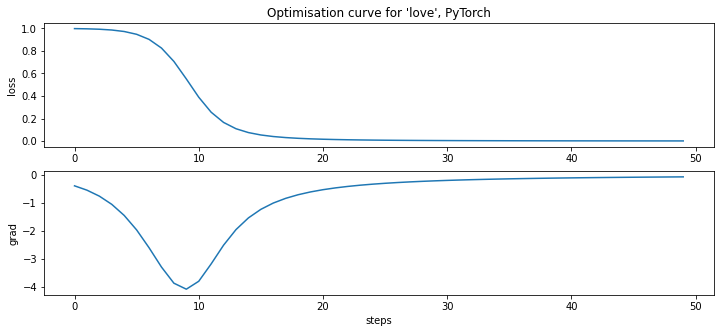

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

plt.subplot(2, 1, 1)
plt.plot(loss)
plt.title("Optimisation curve for 'love', PyTorch")
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(grads)
plt.xlabel('steps')
plt.ylabel('grad')
plt.show()